In [8]:
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel, ViTConfig
from maskgen.vision_models.vision_maskgen import MaskGeneratingModel, convert_to_peft
from maskgen.utils import get_preprocess, collate_fn, load_imagenet
# from maskgen.utils.img_utils import plot_overlap_np
from torch.utils.data import DataLoader
import torch
import json
import os
from tqdm import tqdm
import numpy as np
from typing import Dict, Any
from accelerate import Accelerator

def load_config(config_path: str) -> Dict[str, Any]:
    """Load configuration from JSON file."""
    with open(config_path, 'r') as f:
        config = json.load(f)
    
    # Flatten config for easier access
    flat_config = {}
    flat_config.update(config['evaluation'])
    flat_config.update(config['model'])
    flat_config.update(config['dataset'])
    
    return flat_config

accelerator = Accelerator()
device = accelerator.device

config = load_config('eval_config.json')

In [9]:
from maskgen.utils.save_utils import save_maskgen_results 

save_maskgen_results(config, device)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/afs/crc.nd.edu/user/d/dpan/wd/maskgen-explain/maskgen/vision_models/vision_maskgen.py:174: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by th

Converted base model layers to PEFT: ['encoder.layer.0.attention.attention.query', 'encoder.layer.0.attention.attention.key', 'encoder.layer.0.attention.attention.value', 'encoder.layer.0.attention.output.dense', 'encoder.layer.0.intermediate.dense', 'encoder.layer.0.output.dense', 'encoder.layer.1.attention.attention.query', 'encoder.layer.1.attention.attention.key', 'encoder.layer.1.attention.attention.value', 'encoder.layer.1.attention.output.dense', 'encoder.layer.1.intermediate.dense', 'encoder.layer.1.output.dense', 'encoder.layer.2.attention.attention.query', 'encoder.layer.2.attention.attention.key', 'encoder.layer.2.attention.attention.value', 'encoder.layer.2.attention.output.dense', 'encoder.layer.2.intermediate.dense', 'encoder.layer.2.output.dense', 'encoder.layer.3.attention.attention.query', 'encoder.layer.3.attention.attention.key', 'encoder.layer.3.attention.attention.value', 'encoder.layer.3.attention.output.dense', 'encoder.layer.3.intermediate.dense', 'encoder.layer

Repo card metadata block was not found. Setting CardData to empty.
Processing batches: 100%|██████████| 10/10 [00:18<00:00,  1.90s/it]


Saving pixel-heatmap pairs to: ./new_results/maskgen/pixel_heatmap_pairs.npz


In [12]:
from maskgen.utils.save_utils import load_pixel_heatmap_pairs
npz_path = os.path.join(config['results_path'],'pixel_heatmap_pairs.npz')
dataloader = load_pixel_heatmap_pairs(npz_path, batch_size=1, shuffle=False)

torch.Size([1, 3, 224, 224]) torch.Size([1, 14, 14])


In [2]:
from maskgen.utils.model_utils import get_pred_model, load_exp_and_target_model
from accelerate import Accelerator

accelerator = Accelerator()
device = accelerator.device
target_model, maskgen_model, processor = load_exp_and_target_model(load_config('eval_config.json'), device)
img_mean, img_std = processor.image_mean, processor.image_std

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/afs/crc.nd.edu/user/d/dpan/wd/maskgen-explain/maskgen/vision_models/vision_maskgen.py:174: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by th

Converted base model layers to PEFT: ['encoder.layer.0.attention.attention.query', 'encoder.layer.0.attention.attention.key', 'encoder.layer.0.attention.attention.value', 'encoder.layer.0.attention.output.dense', 'encoder.layer.0.intermediate.dense', 'encoder.layer.0.output.dense', 'encoder.layer.1.attention.attention.query', 'encoder.layer.1.attention.attention.key', 'encoder.layer.1.attention.attention.value', 'encoder.layer.1.attention.output.dense', 'encoder.layer.1.intermediate.dense', 'encoder.layer.1.output.dense', 'encoder.layer.2.attention.attention.query', 'encoder.layer.2.attention.attention.key', 'encoder.layer.2.attention.attention.value', 'encoder.layer.2.attention.output.dense', 'encoder.layer.2.intermediate.dense', 'encoder.layer.2.output.dense', 'encoder.layer.3.attention.attention.query', 'encoder.layer.3.attention.attention.key', 'encoder.layer.3.attention.attention.value', 'encoder.layer.3.attention.output.dense', 'encoder.layer.3.intermediate.dense', 'encoder.layer

In [4]:
from maskgen.utils.data_utils import load_imagenet
from maskgen.utils.data_utils import get_imagenet_dataloader
# dataloader = get_imagenet_dataloader(split='tiny', 
#                                      batch_size=100, 
#                                      processor=processor, 
#                                      shuffle=False,
#                                      num_samples=5000)


Repo card metadata block was not found. Setting CardData to empty.


In [23]:
from torch.utils.data import Dataset, DataLoader

def save_pixel_heatmap_pairs(pixel_values, heatmaps, save_path):
    """Save pixel values and heatmaps as paired data"""
    # Convert to numpy if needed
    if torch.is_tensor(pixel_values):
        pixel_values = pixel_values.cpu().numpy()
    if torch.is_tensor(heatmaps):
        heatmaps = heatmaps.cpu().numpy()
    
    # Save paired data
    np.savez(save_path, 
             pixel_values=pixel_values, 
             heatmaps=heatmaps)

class PixelHeatmapDataset(Dataset):
    def __init__(self, npz_path):
        data = np.load(npz_path)
        self.pixel_values = data['pixel_values']
        self.heatmaps = data['heatmaps']
        
    def __len__(self):
        return len(self.pixel_values)
    
    def __getitem__(self, idx):
        return {
            'pixel_values': torch.from_numpy(self.pixel_values[idx]),
            'heatmap': torch.from_numpy(self.heatmaps[idx])
        }

def load_pixel_heatmap_pairs(npz_path, batch_size=32, shuffle=True):
    """Load saved pairs into a DataLoader"""
    dataset = PixelHeatmapDataset(npz_path)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [24]:
def save_maskgen_results(config, device):
    all_inputs = []
    all_heatmaps = []
    save_path = config['results_path']

    # get models 
    target_model, maskgen_model, processor = load_exp_and_target_model(config, device)

    # get dataloader
    dataloader = get_imagenet_dataloader(split='tiny', 
                                         batch_size=config['batch_size'], 
                                         processor=processor, 
                                         shuffle=False,
                                         num_samples=config['num_samples'])

    for idx, batch in tqdm(enumerate(dataloader), total=len(dataloader), desc="Processing batches"):
        inputs = batch['pixel_values'].to(device)
        with torch.no_grad():
            predicted_class_idx = target_model(inputs).logits.argmax(-1)
            heatmap = maskgen_model.attribute_img(inputs, predicted_class_idx.unsqueeze(1), image_size=224, patch_size=16)
            
            # Convert current batch to numpy and append to lists
            inputs_np = inputs.cpu().numpy()
            heatmap_np = heatmap.cpu().numpy()
            all_inputs.append(inputs_np)
            all_heatmaps.append(heatmap_np)
            
    all_inputs = np.concatenate(all_inputs, axis=0)
    all_heatmaps = np.concatenate(all_heatmaps, axis=0)
    # ensure save path exists
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    save_path = os.path.join(save_path, 'pixel_heatmap_pairs.npz')
    save_pixel_heatmap_pairs(all_inputs, all_heatmaps, save_path)



In [25]:
# Load the saved pairs into a dataloader
loaded_loader = load_pixel_heatmap_pairs('all_inputs_heatmap_pairs.npz', batch_size=32, shuffle=False)

In [26]:
for idx, batch in enumerate(loaded_loader):
    pixel_values = batch['pixel_values']
    heatmaps = batch['heatmap']
    # Do something with the pixel values and heatmaps
    break

In [27]:
pixel_values.shape, heatmaps.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32, 14, 14]))

Predicted class: chain saw, chainsaw


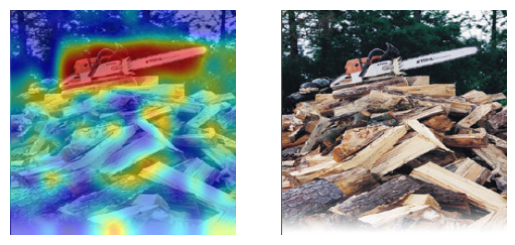

In [6]:
import requests
from PIL import Image
from maskgen.utils.img_utils import plot_overlap_np

# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
# url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
# url = "http://farm9.staticflickr.com/8490/8179481059_41be7bf062_z.jpg"
# url = "http://farm1.staticflickr.com/76/197438957_b20800e7cf_z.jpg"
# url = "http://farm3.staticflickr.com/2284/5730266001_7d051b01b7_z.jpg"
# url = "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01491361_tiger_shark.JPEG?raw=true"
url = "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n03000684_chain_saw.JPEG?raw=true"
# url = "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n04009552_projector.JPEG?raw=true"
image = Image.open(requests.get(url, stream=True).raw)

with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    img = inputs['pixel_values']
    img = img.to(device)
    predicted_class_idx = target_model(img).logits.argmax(-1).item()
    secondary_class_idx = target_model(img).logits.argsort(descending=True)[0][1].item()

label = predicted_class_idx
# label = secondary_class_idx
label = torch.tensor([label]).to(device)

print("Predicted class:", target_model.config.id2label[label.item()])

# heatmap = torch.sigmoid(sim_logits).reshape(N, size, size)
heatmap = maskgen_model.attribute_img(img, label.unsqueeze(1), image_size=224, patch_size=16)
# heatmap = sim_logits.reshape(N, size, size)

heatmap = heatmap.squeeze(0).detach().cpu().numpy()
img = img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
img_int, heatmap_img = plot_overlap_np(img, heatmap, img_mean, img_std)

array([[0.02291978, 0.01823126, 0.14843228, 0.1209743 , 0.2352373 ,
        0.20099738, 0.11311324, 0.37385315, 0.00182686, 0.14073817,
        0.05224533, 0.03638064, 0.02110025, 0.05094557],
       [0.14863859, 0.04189699, 0.0018423 , 0.16620979, 0.09373263,
        0.03943025, 0.00207421, 0.13891803, 0.2548459 , 0.22266743,
        0.22612086, 0.01346492, 0.0219104 , 0.19108069],
       [0.26804745, 0.04814665, 0.0038446 , 0.5722503 , 0.6670517 ,
        0.9191961 , 0.77859277, 0.8552832 , 0.89173895, 0.8188308 ,
        0.79389113, 0.8932843 , 0.5552863 , 0.48042265],
       [0.06999721, 0.21477906, 0.00193515, 0.9131405 , 0.9159174 ,
        0.94377613, 0.8370257 , 0.89487666, 0.79147726, 0.87537074,
        0.90697795, 0.74329007, 0.27367982, 0.5587254 ],
       [0.32286185, 0.57013524, 0.09346838, 0.8948615 , 0.9313733 ,
        0.7718173 , 0.82127655, 0.8204308 , 0.7265447 , 0.4069364 ,
        0.50876737, 0.48757234, 0.5880315 , 0.3748338 ],
       [0.44931796, 0.6726785 , 0.6